<a href="https://colab.research.google.com/github/kunalpohakar/Amenity-Detection-using-Detectron2/blob/main/00_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install Detectron2 Library**

In [ ]:
!pip install pyyaml

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

torch:  2.2 ; cuda:  cu121
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-vs569k8n
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-vs569k8n
  Resolved https://github.com/facebookresearch/detectron2.git to commit 92ae9f0b92aba5867824b4f12aa06a22a60a45d3
  Preparing metadata (setup.py) ... done


In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
pwd

'/content'

In [5]:
%cd /content/drive/MyDrive/object_detection

/content/drive/MyDrive/object_detection


In [6]:
!ls

00_object_detection.ipynb  node_modules			  predictions		 test
app.py			   object_detection.v1i.coco.zip  README.dataset.txt	 train
images			   output			  README.roboflow.txt	 valid
model_config.yaml	   package-lock.json		  retinanet_model_final


In [ ]:
!unzip object_detection.v1i.coco.zip

Archive:  object_detection.v1i.coco.zip
replace README.dataset.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# **Register Data**

In [39]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("version11", {}, "./train/_annotations.coco.json", "./train")

In [40]:
from detectron2.data.datasets import register_coco_instances

# Define the number of categories in your dataset
num_categories = 24  # Replace 24 with the actual number of categories in your dataset

# Mapping dictionary to remap category IDs
category_id_mapping = {
    original_id: new_id for new_id, original_id in enumerate(range(num_categories), start=1)
}

# Register COCO instances with the correct metadata and category mapping
register_coco_instances("v16", {}, "./train/_annotations.coco.json", "./train")

# Fetch metadata and dataset dicts
sample_metadata = MetadataCatalog.get("v16")
dataset_dicts = DatasetCatalog.get("v16")


WARNING [04/29 00:01:11 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/29 00:01:11 d2.data.datasets.coco]: Loaded 90 images in COCO format from ./train/_annotations.coco.json


In [9]:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("v7", {}, "./train/_annotations.coco.json", "./train")

In [10]:
# sample_metadata = MetadataCatalog.get("v7")
# dataset_dicts = DatasetCatalog.get("v7")

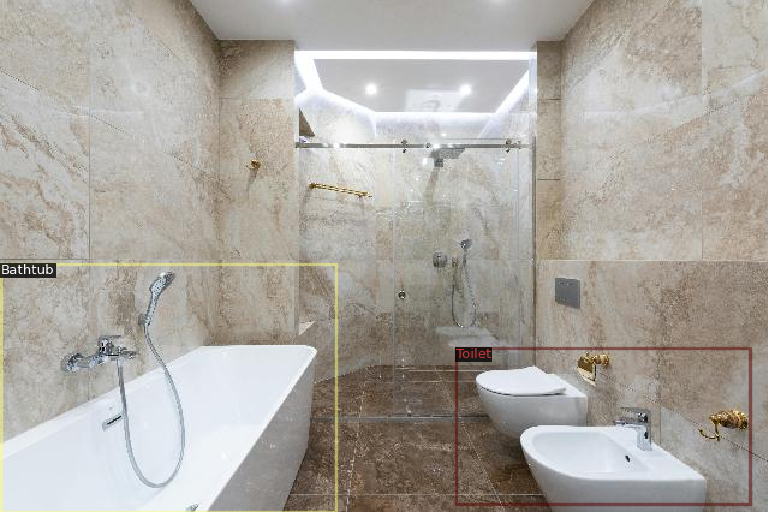

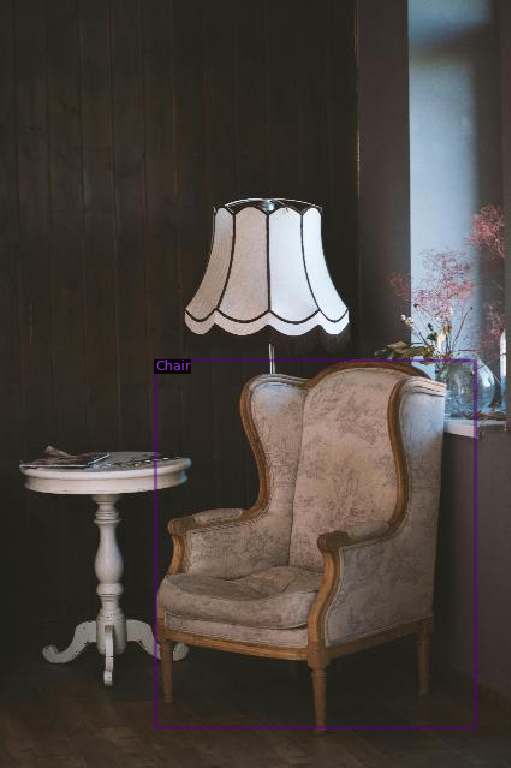

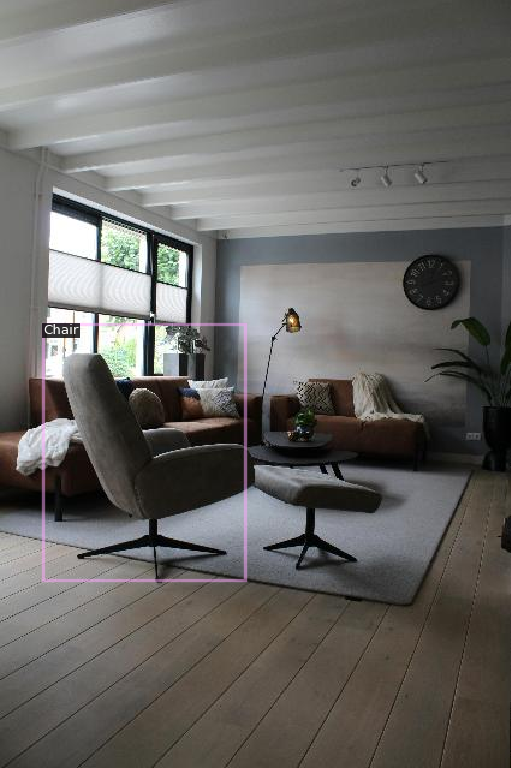

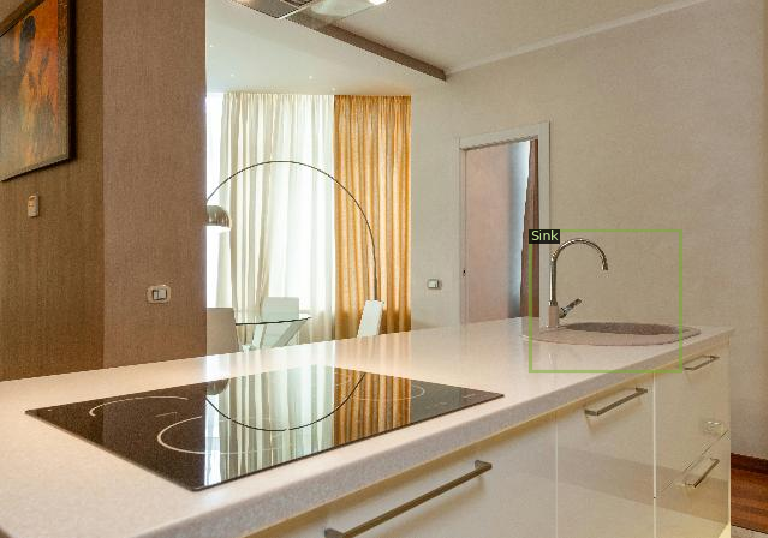

In [41]:
import random

for d in random.sample(dataset_dicts, 4):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=sample_metadata, scale=1.2)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

# **Training**

In [42]:
import os
import torch

# Set environment variable to enable CUDA launch blocking
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Additional configurations to help with CUDA error
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = True

In [43]:
# from detectron2.engine import DefaultTrainer

# cfg = get_cfg()
# cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
# cfg.DATASETS.TRAIN = ("v1",)
# cfg.DATASETS.TEST = ()
# cfg.DATALOADER.NUM_WORKERS = 2
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
# cfg.SOLVER.IMS_PER_BATCH = 2
# cfg.SOLVER.BASE_LR = 0.0025  # pick a good LR
# cfg.SOLVER.MAX_ITER = 100   # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6  # (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# # NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

# os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg)
# trainer.resume_or_load(resume=True)
# trainer.train()

# Train the model
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("version11",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
# cfg.MODEL.WEIGHTS =model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_3x.yaml")
cfg.MODEL.WEIGHTS = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300   # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 24  # (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# Set device to CPU
cfg.MODEL.DEVICE = "cpu"


# # Update model configuration with correct number of classes
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6

# Create trainer
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()


# Load trained weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("v16", )
predictor = DefaultPredictor(cfg)


[04/29 00:02:19 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [44]:
import json

# Load the annotations file
with open("/content/drive/MyDrive/object_detection/train/_annotations.coco.json", "r") as f:
    coco_data = json.load(f)

# Extract the categories from the annotations file
categories = coco_data["categories"]

# Count the number of unique category IDs
num_classes = len(categories)

print("Number of classes:", num_classes)


Number of classes: 24


In [45]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("v16", )
predictor = DefaultPredictor(cfg)

[04/29 00:02:36 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


In [46]:
# Save the trained model weights
model_path = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.WEIGHTS = model_path
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 24

In [47]:
# Save model configuration
config_path = "model_config.yaml"
with open(config_path, "w") as f:
    f.write(cfg.dump())

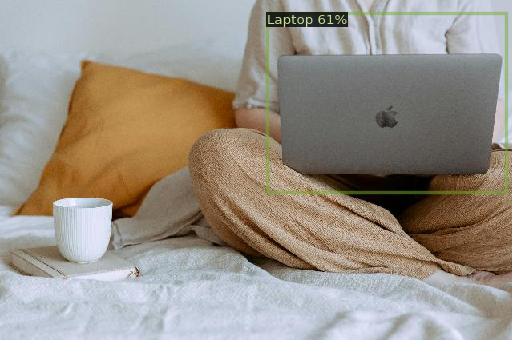

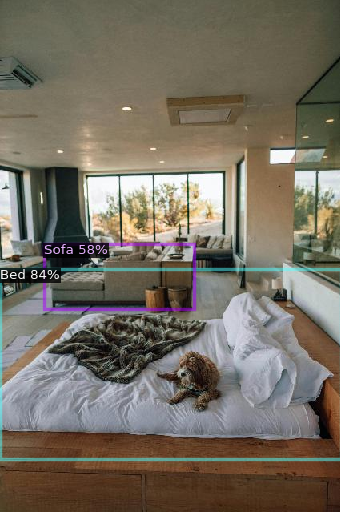

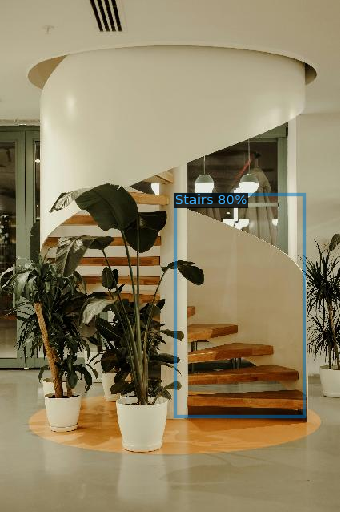

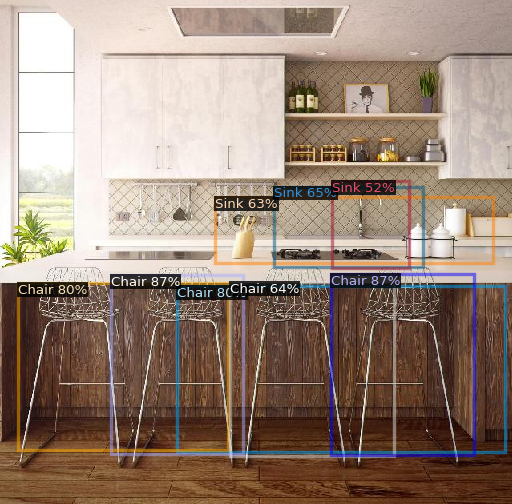

In [48]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 4):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=sample_metadata,
                   scale=0.8,
                  #  instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [35]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("valid5", {}, "./valid/_annotations.coco.json", "./valid")


In [36]:
from detectron2.evaluation import COCOEvaluator
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import inference_on_dataset

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.DEVICE = 'cpu' # cpu
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 24
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/object_detection/output/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)

evaluator = COCOEvaluator("valid5", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "valid5")
inference_on_dataset(trainer.model, val_loader, evaluator)

[04/28 23:51:46 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/object_detection/output/model_final.pth ...
WARNING [04/28 23:51:47 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/28 23:51:47 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/28 23:51:47 d2.data.datasets.coco]: Loaded 26 images in COCO format from ./valid/_annotations.coco.json
[04/28 23:51:47 d2.data.build]: Distribution of instances among all 24 categories:
|   category   | #instances   |  category   | #instances   |  category  | #instances   |
|:------------:|:-------------|:-----------:|:-------------|:----------:|:-------------|
|   amenity    | 0            |     AC      | 0            |  Bathtub   | 0            |
|     Bed      | 1            | Celling Fan | 1            |   Chair    | 8  

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[04/28 23:52:03 d2.evaluation.evaluator]: Inference done 1/26. Dataloading: 0.8269 s/iter. Inference: 14.5555 s/iter. Eval: 0.0009 s/iter. Total: 15.3854 s/iter. ETA=0:06:24
[04/28 23:52:11 d2.evaluation.evaluator]: Inference done 2/26. Dataloading: 0.4162 s/iter. Inference: 11.4306 s/iter. Eval: 0.0006 s/iter. Total: 11.8501 s/iter. ETA=0:04:44
[04/28 23:52:18 d2.evaluation.evaluator]: Inference done 3/26. Dataloading: 0.2787 s/iter. Inference: 9.8622 s/iter. Eval: 0.0006 s/iter. Total: 10.1438 s/iter. ETA=0:03:53
[04/28 23:52:26 d2.evaluation.evaluator]: Inference done 4/26. Dataloading: 0.2104 s/iter. Inference: 9.4310 s/iter. Eval: 0.0006 s/iter. Total: 9.6444 s/iter. ETA=0:03:32
[04/28 23:52:31 d2.evaluation.evaluator]: Inference done 5/26. Dataloading: 0.1686 s/iter. Inference: 8.6386 s/iter. Eval: 0.0005 s/iter. Total: 8.8099 s/iter. ETA=0:03:05
[04/28 23:52:40 d2.evaluation.evaluator]: Inference done 6/26. Dataloading: 0.0000 s/iter. Inference: 9.1230 s/iter. Eval: 0.0005 s/ite

OrderedDict([('bbox',
              {'AP': 19.30661816135792,
               'AP50': 39.275774381949475,
               'AP75': 21.33766501650165,
               'APs': nan,
               'APm': 14.099009900990097,
               'APl': 20.932698311847993,
               'AP-amenity': nan,
               'AP-AC': nan,
               'AP-Bathtub': nan,
               'AP-Bed': 13.33333333333333,
               'AP-Celling Fan': 60.0,
               'AP-Chair': 10.75941879902276,
               'AP-Fan': 0.0,
               'AP-Gas Stove': nan,
               'AP-Lamp': nan,
               'AP-Laptop': 59.900990099009896,
               'AP-Mirror': nan,
               'AP-Pillow': 0.18387553041018384,
               'AP-Refrigerator': nan,
               'AP-Shelf': nan,
               'AP-Sink': 8.205445544554456,
               'AP-Sofa': 8.791404134914913,
               'AP-Stairs': 0.0,
               'AP-Table': 22.297029702970296,
               'AP-Television': 44.6732673267326

In [25]:
!pip install streamlit -q
!npm install localtunnel

npm WARN saveError ENOENT: no such file or directory, open '/content/drive/MyDrive/object_detection/package.json'
npm WARN enoent ENOENT: no such file or directory, open '/content/drive/MyDrive/object_detection/package.json'
npm WARN object_detection No description
npm WARN object_detection No repository field.
npm WARN object_detection No README data
npm WARN object_detection No license field.

+ localtunnel@2.0.2
updated 1 package and audited 36 packages in 1.06s

3 packages are looking for funding
  run `npm fund` for details

found 2 moderate severity vulnerabilities
  run `npm audit fix` to fix them, or `npm audit` for details


In [49]:
!streamlit run app.py &>/content/logs.txt & !npx localtunnel --port 8501 & curl ipv4.icanhazip.com

/bin/bash: line 1: !npx: command not found
34.48.7.224


In [50]:
!streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8502
  External URL: http://34.48.7.224:8502

npx: installed 22 in 2.556s
your url is: https://spotty-phones-drop.loca.lt
  Stopping...
^C
